# Genre Classification

#### Overview 

The goal is to use features of songs, using the *Spotify Song Attributes* dataset, to group songs into their respective "genres" and then create a genre predictor for new songs not in the dataset. 

To do this, first I will reduce the dimensionality of the data to just two features. From here, I can use K-means clustering to decide where the "genres" should be.

### Imports

I will be using `numpy` and `pandas` for analysis, `sklearn` and `keras` for learning, and `matplotlib` for plotting.

In [1]:
# analysis
import numpy as np
import pandas as pd

# learning
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from keras import models
from keras import layers

# plotting
import matplotlib.pyplot as plt

# warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## The Data

Firstly, the data must be read. It comes in a pretty annoying format, so the columns are rearanged and useless columns are dropped. Below is a preview of the data, as well as its shape.

In [2]:
# read data
spotify_top_2017 = pd.read_csv('/Users/Mattmacks/Desktop/CISC 350/Final/data.csv')

# rearange data
cols = spotify_top_2017.columns.tolist()
cols = cols[-2:] + cols[1:-3]
spotify_top_2017 = spotify_top_2017[cols]

# preview the data
n_instances, n_features = spotify_top_2017.shape
print('Number of Instances:', n_instances)
print('Number of Features:', n_features)
spotify_top_2017.head(5)

Number of Instances: 2017
Number of Features: 15


,song_title,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Mask Off,Future,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,Redbone,Childish Gambino,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,Xanny Family,Future,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,Master Of None,Beach House,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,Parallel Lines,Junior Boys,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


#### Features:
- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- **duration_ms**: The duration of the track in milliseconds.

- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

- **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

- **time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

#### Normalization
Since we only want numeric data, the `song_title` and `artist` columns are temporarily dropped. And then the data is normalized using `sklearn.StandardScaler()`.

In [3]:
num_data = spotify_top_2017.drop(columns=['song_title', 'artist'])

standard_scaler = StandardScaler()
x_std = standard_scaler.fit_transform(num_data)

## Dimensionality Reduction

The first step is to reduce the dimensionality of the 13 remaining columns down to just 2. To do this, I will use t-SNE from the `sklearn` library.

In [4]:
tsne = TSNE(n_components=2, random_state=0)
x_2d = tsne.fit_transform(x_std)

Here is a preview, and the shape of the reduced data.

In [5]:
new_data = pd.DataFrame(data=x_2d, columns=['X', 'Y'])

n_instances, n_features = new_data.shape
print('Number of Instances:', n_instances)
print('Number of Features:', n_features)
new_data.head()

Number of Instances: 2017
Number of Features: 2


,X,Y
0,12.065855,44.677094
1,-26.745543,-6.615260
2,11.728292,27.820337
3,-29.859205,-33.301167
4,21.771280,-25.189959


The number of features is now 2, so we can now actually visualize this data. 

### Visualization of Reduced Data

I'll use `matplotlib` to set up a simple scatter chart.

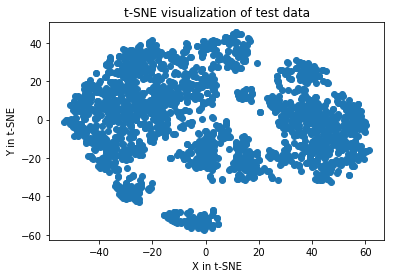

In [6]:
plt.figure()
plt.scatter(x=x_2d[:,0], y=x_2d[:,1])
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.title('t-SNE visualization of test data')
plt.show()

When looking at this data, it seems to form some obvious groups. The next step is to determine what those optimal groups are, and then visualize the groups. to do this, we will use K-Means Clustering.

## K-Means Clustering

This will use a number of functions. 

>`euclidian(a, b)`

This well be the main metric of the algorithm. This calculates the euclidian distance between two points. 

In [7]:
def euclidian(a, b):
    return np.linalg.norm(a-b)

>`kmeans(data, k, epsilon=0)`

This is the meat. This actually finds the centroids and clusters of the given dataset. `k` is the number of clusters, and `epsilon` is a  threshhold value of when to stop clustering. 

In [8]:
def kmeans(data, k, epsilon=0):
        
    dataset = data
    num_instances, num_features = dataset.shape
    
    prototypes = dataset[np.random.randint(0, num_instances - 1, size=k)]
    prototypes_old = np.zeros(prototypes.shape)
    
    clusters = np.zeros((num_instances, 1))
    norm = euclidian(prototypes, prototypes_old)
    iteration = 0
    
    while norm > epsilon:
        iteration += 1
        norm = norm = euclidian(prototypes, prototypes_old)
        prototypes_old = prototypes
        
        for index_instance, instance in enumerate(dataset):
            dist_vector = np.zeros((k, 1))
            
            for index_prototype, prototype in enumerate(prototypes):
                dist_vector[index_prototype] = euclidian(prototype, instance)
            
            clusters[index_instance, 0] = np.argmin(dist_vector)
        
        tmp_prototypes = np.zeros((k, num_features))
        
        for index in range(len(prototypes)):
            instances_close = [i for i in range(len(clusters)) if clusters[i] == index]
            prototype = np.mean(dataset[instances_close], axis=0)
            tmp_prototypes[index, :] = prototype
            
        prototypes = tmp_prototypes
        
    return prototypes, clusters, iteration

>`plot(dataset, clusters)`

This plots a given dataset and colors the clusters different colors. 

In [9]:
def plot(dataset, clusters):

    fig, ax = plt.subplots(figsize=(10, 6))
    
    plt.scatter(dataset[:, 0], dataset[:, 1], c=clusters.T[0])
            
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    ax.set_title('t-SNE visualization of test data', size=20)
    plt.show()

> `combine_data(dataset, clusters, centroids)`

This joins the different data returned by the `kmeans` function into one table. 

In [10]:
def combine_data(dataset, clusters, centroids):
    data_df = pd.DataFrame(data=dataset, columns=['x','y'])
    clusters_df = pd.DataFrame(data=clusters, columns=['cluster'])
    centroids_df = pd.DataFrame(data=centroids, columns=['c_x', 'c_y'])

    tmp_df = data_df.join(clusters_df)
    combined_data = tmp_df.join(centroids_df, on='cluster')
    return combined_data.values

> `get_dist(data, i)`

This returns the euclidian distance between two points in the combined data set at index `i`. 

In [11]:
def get_dist(data, i):
    pt = np.array([data[i, 0], data[i, 1]])
    c_pt = np.array([data[i, 3], data[i, 4]])
    return euclidian(c_pt, pt)

> `cluster_mean(data, c)`

This returns the mean distance from each point to the centroid for a given cluster `c`.

In [12]:
def cluster_mean(data, c):
    cluster_means = []
    for i in range(len(data)):
        if combined_data[i, 2] == c:
            cluster_means.append(get_dist(combined_data, i))
    
    mean = np.array(cluster_means).mean()
    return mean

### Finding the Best K Value

With all the necessary bits done, now we need to know what the ideal number or clusters to make is. 
To do this, we will calculate the clusters for many `k` values, say 1 - 10. We will then calculate sum of the mean squared errors from each point to the average of the cluster for each `k` value.

In [13]:
dataset = new_data.values

sse = {}
its = {}
for k in range(1, 10):
    sse[k] = 0
    centroids, clusters, iteration = kmeans(dataset, k)
    combined_data = combine_data(dataset, clusters, centroids)
    for c in range(len(centroids)):
        mean = cluster_mean(combined_data, c)
    
        for i in range(len(combined_data)):
            if combined_data[i, 2] == c:
                sse[k] += (get_dist(combined_data, i) - mean) ** 2
                
    its[k] = iteration

Now we can find the optimal `k` value.

First, I plot the MSE (scaled down), then the number of iterations it takes to cluster the data. I then calculate a new metric, a sort of computational complexity value (also scaled down) by multiplying k, MSE, and Iterations. The minimum value of this will be the `k` value I use. Using the "elbow method" we should see 4 usually being our optimal `k`.

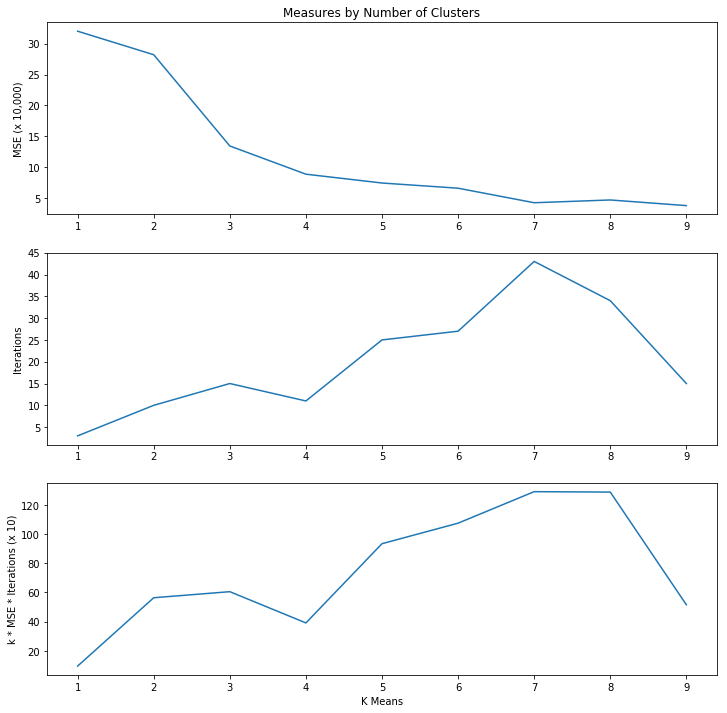

In [14]:
x = np.fromiter(sse.keys(), dtype=float)
y1 = np.fromiter(sse.values(), dtype=float) / 10000
y2 = np.fromiter(its.values(), dtype=float)
y3 = (y2 * y1 * x) / 10

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

ax1.plot(x, y1)
ax1.set(title='Measures by Number of Clusters', ylabel='MSE (x 10,000)')

ax2.plot(x, y2)
ax2.set(ylabel='Iterations')

ax3.plot(x, y3)
ax3.set(xlabel='K Means', ylabel='k * MSE * Iterations (x 10)')

fig.show()

We can see the error starts to dimish returns around 6. So, now we can run the algorithm one more time using 6 as our `k` value. We can then plot the data and color it correctly.

### Clustered Data

Using the minimum value of the computational measure, we can decide the final `k` value. I only use after `k = 4` becasue before that, there is no good grouping. 

min = 4


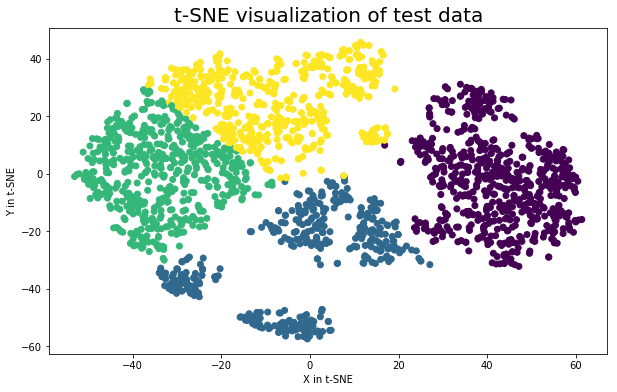

In [15]:
min = np.argmin(y3[3:]) + 4

centroids, clusters, iteration = kmeans(dataset, min)
print('min =', min)
plot(dataset, clusters)

## Do the Clusters Make Sense?

This is something I would like to investigate more, but would need quite a bit of time to actually listen to 2017 songs..

But, at least as a sample, I will lay out 5 random songs in each cluster, maybe a more musical brain could identify similarities at sight. 

In [16]:
disc = spotify_top_2017[['song_title', 'artist']].join(
       pd.DataFrame(data=clusters, columns=['cluster']))

clustered_data = []

for i in range(len(centroids)):
    cluster = []
    for item in disc.values:
        if item[2] == i:
            to_append = [item[0][:30], item[1][:30]]
            cluster.append(to_append)
            
    clustered_data.append(cluster)

for i in range(len(centroids)):
    data = clustered_data[i]
    df = pd.DataFrame(data=data, columns=['song_title', 'artist']).sample(5)
    print('Cluster:', i + 1)
    print(df.to_string(col_space = 30))
    
    if i != len(centroids):
        print()

Cluster: 1
                                                   song_title                         artist
184                             Good Life - Original 12'' Mix                     Inner City
223                                              Play by Play                  Autre Ne Veut
138                                                 Affection                Crystal Castles
246                                               My Sunshine                      Ty Segall
574                                      (You Drive Me) Crazy                 Britney Spears

Cluster: 2
                                                    song_title                         artist
255                                                  Arrogance                       Traitors
292                                              Leave Me Here                      Triosence
219                              Episode I - Duel of The Fates                  John Williams
393                                        

## Building a Model

Now, since we have clusters that seem to make sense, we can build a neural network to predict what cluster new songs might belong to.

First, partition the data into testing and training datasets, and then use one-hot-encoding on the targets, which are now the cluster labels.

In [17]:
train_data = x_std[:1800]
train_targets = clusters[:1800]

x_test = x_std[1800:]
test_targets = clusters[1800:]

from keras.utils.np_utils import to_categorical

one_hot_train_targets = to_categorical(train_targets)
y_test = to_categorical(test_targets)

#### Model Architecture

The model will have 2 hidden layers with `2 + min` neurons each, using `relu` activation. The output layers will use `softmax` to output a probability distribution of each cluster. 

I put this is a function so it is easier to create many models. 

In [18]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(min + 2, activation='relu', input_shape=(13, )))
    model.add(layers.Dense(min + 2, activation='relu'))
    model.add(layers.Dense(min, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Validation

In [19]:
x_val = train_data[:300]
x_train = train_data[300:]

y_val = one_hot_train_targets[:300]
y_train = one_hot_train_targets[300:]

#### Initial Evaluation

In [20]:
model = build_model()
results = model.evaluate(x_test, y_test)
print(results[1])

217/217 [==============================] - 0s 118us/step
0.285714286401


We reach about **25%** accuracy.

#### Training

We will initially train for 50 epochs, using a batch size of 32. 

In [21]:
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=0)

#### Plotting the Loss and Accuracy

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

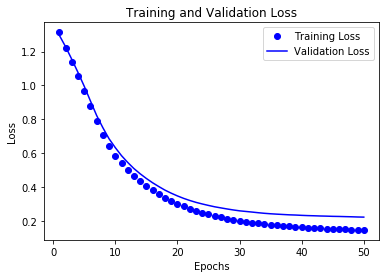

In [23]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

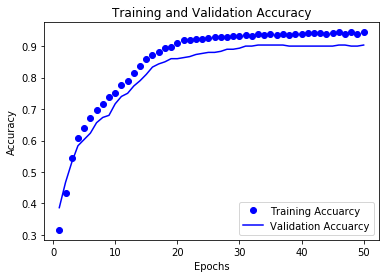

In [24]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training Accuarcy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuarcy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Overfitting starts to occur around 35 epochs, so we will create one final model.

In [25]:
model = build_model()
model.fit(x_train,
          y_train,
          epochs=35,
          batch_size=32,
          validation_data=(x_val, y_val),
          verbose=0)

In [26]:
results = model.evaluate(x_test, y_test)
print(results[1])

217/217 [==============================] - 0s 64us/step
0.912442393841


We reach about **90%**!

From here, I would like to figure out how to use the Spotify API to get more data.